IMPORTANT (for Google Colab): `Runtime` 🡒 `Change runtime type` 🡒 `Hardware accelerator` 🡒 `(GPU)`

In [ ]:
%%capture
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from time import gmtime, strftime

!pip install transformers
from transformers import BertTokenizer

import torch
device = torch.device('cuda')

# it's for apply progress bar
from tqdm.auto import tqdm 
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# global vars for changing them and finding the optimal ones
MAX_LENGTH = 128
BATCH_SIZE = 16
LEARNING_RATE = 3e-05
EPOCHS_NUM = 2

In [ ]:
# set the seed value all over the place to make this reproducible
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
# google drive mounting
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_json('./drive/MyDrive/nlp/train.jsonl', lines=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Called below `encode_plus` will do all for preparing data:

* Tokenize the sentence (both at the same time)
* Prepend the `[CLS]` token to the start
* Append the `[SEP]` token to the end
* Put `[SEP]` between question and passage
* Map tokens to their IDs
* Pad or truncate the sentence to `max_length`
* Create attention masks for `[PAD]` tokens (considering that we have two sentences in `tokens`)


In [ ]:
# preparing data for BERT model
df['encoded_dict'] = df.progress_apply(lambda x: tokenizer.encode_plus(
                                                 text = x['question'],         # 1st sentence to encode
                                                 text_pair = x['passage'],     # 2nd sentence to encode
                                                 add_special_tokens = True,    # add '[CLS]' and '[SEP]'
                                                 max_length = MAX_LENGTH,      # pad & truncate all sentences
                                                 pad_to_max_length = True,
                                                 return_attention_mask = True, # construct attention masks
                                                 return_tensors = 'pt'         # return pytorch tensors
                                                 ), axis=1)

  0%|          | 0/9427 [00:00<?, ?it/s]

In [ ]:
# extracting useful features from the dictionary
df['input_ids'] = df['encoded_dict'].apply(lambda x: x['input_ids'])
df['attention_mask'] = df['encoded_dict'].apply(lambda x: x['attention_mask'])

In [ ]:
# BERT needs integer numbers as classification marks 
df['label'] = df['label'].apply(int)

In [ ]:
# transformation the data to tensor form for further putting it into the model
input_ids_tf = torch.cat(list(df['input_ids']), dim=0)
attention_masks_tf = torch.cat(list(df['attention_mask'].values), dim=0)
labels_tf = torch.tensor(list(df['label']))

Randomized splitting data into training and validation parts. 

In [ ]:
from torch.utils.data import TensorDataset, random_split

# combine the training inputs into a TensorDataset
dataset = TensorDataset(input_ids_tf, attention_masks_tf, labels_tf)

# calculating sizes of train/val sets
train_size = int(.9 * len(dataset))
val_size = len(dataset) - train_size

# divide the dataset by randomly selecting samples
train_df, val_df = random_split(dataset, [train_size, val_size])

print(f'training size is {train_size}')
print(f'validation size is {val_size}')

training size is 8484
validation size is 943


Since the training process does not use the whole dataset, but only batches from it, for saving speed and memory, we create DataLoader-objects that will help us to use exactly as much memory as we need.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler

# the DataLoader needs to know our batch size for training, so we specify it here for fine-tuning BERT on
# a specific task, the authors recommend a batch size of 16 or 32
batch_size = BATCH_SIZE

# creatinh the DataLoaders for our training and validation sets, we'll take samples randomly
train_dataloader = DataLoader(
                     train_df,                          # the training samples
                     sampler = RandomSampler(train_df), # select batches randomly
                     batch_size = batch_size)           # trains with this batch size
        
val_dataloader = DataLoader(
                     val_df,                            # the validation samples
                     sampler = RandomSampler(val_df),   # pull out batches sequentially
                     batch_size = batch_size)           # evaluate with this batch size

Here we're gonna load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. And we'll use here this model but not BertForQuestionAnswering, for example, because of we are not interested in a complex answer to question. In essence, we just need to classify Boolean sequences of indexes that already contain information from the question and passage at the same time. 

In [ ]:
from transformers import BertForSequenceClassification, BertConfig

model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',          # choosing the 12-layer BERT model
        num_labels = 2,               # the number of output labels is 2   
        output_attentions = False,    # whether the model returns attentions weights
        output_hidden_states = False, # whether the model returns all hidden-states
)

In [ ]:
%%capture

# tell pytorch to run this model on the GPU.
model.cuda()

The authors of the article on the fine-tuning of the BERT model recommend to take huperparameters from the following list:
* `batch size`: 16, 32
* `learning rate`: 5e-5, 3e-5, 2e-5
* `number of epochs`: 2, 3, 4

Below we just initialize the things needed to create a training loop. More about them by the links mentioned in the source article.

In [ ]:
from transformers import get_linear_schedule_with_warmup, AdamW

optimizer = AdamW(model.parameters(),
                  lr = LEARNING_RATE)  # args.learning_rate - default is 5e-5

epochs_num = EPOCHS_NUM

# total number of training steps is [number of batches] x [number of epochs]
total_steps = len(train_dataloader) * epochs_num

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # default value in run_glue.py (more in source)
                                            num_training_steps = total_steps)

In [ ]:
# helping function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Plan for our training loop:
Training:

* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Clear out the gradients calculated in the previous pass
* Forward pass (feed input data through the network)
* Backward pass (backpropagation)
* Tell the network to update parameters with optimizer.step()
* Track variables for monitoring progress

Evalution:

* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Forward pass (feed input data through the network)
* Compute loss on our validation data and track variables for monitoring progress

In [ ]:
# we'll store a number of quantities such as training and validation loss, validation accuracy, and timings
training_stats = []

# measure the total training time for the whole run
total_t0 = time.time()

# for each epoch ...
for epoch_i in range(epochs_num):
    
    ## TRAINING PART

    print(f'EPOCH {epoch_i+1}/{epochs_num}:')
    print('  Training...')

    # measure how long the training epoch takes.
    t0 = time.time()

    # reset the total loss for this epoch.
    total_train_loss = 0

    # put the model into training mode, the call to `train` just changes the *mode*, it doesn't *perform* the training
    model.train()

    # for each batch of training data ...
    for step, batch in enumerate(train_dataloader):

        # progress update every 40 batches
        if step % 40 == 0 and not step == 0:
            # calculate elapsed time in minutes
            elapsed = strftime('%H:%M:%S', gmtime((time.time() - t0)))
            
            # report progress
            print(f'    batch {step:>3,} of {len(train_dataloader):>3,} - elapsed: {elapsed}')

        # batch contains three pytorch tensors: [0] - input ids, [1] - attention masks, [2]-  labels;
        # as we unpack the batch, we'll also copy each tensor to the GPU using the 'to' method
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # always clear any previously calculated gradients before performing a backward pass
        model.zero_grad()

        # performing a forward pass (evaluate the model on this training batch), it returns 
        # the loss (because we provided labels) and the 'logits' - the model outputs prior to activation
        #
        # in common case 'model' returns different parameters depending on what arguments are given and what flags are set:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels).to_tuple()

        # accumulating the training loss over all of the batches so that we can calculate the average loss at the end;
        # loss is a tensor containing a single value, and we get it using item()
        total_train_loss += loss.item()

        # perform a backward pass to calculate the gradients
        loss.backward()

        # gradients normalizing to prevent the 'exploding gradients' problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters and take a step using the computed gradient
        optimizer.step()

        # update the learning rate
        scheduler.step()

    # calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # measure how long this epoch took
    training_time = strftime('%H:%M:%S', gmtime((time.time() - t0)))

    print(f'\n    average training loss: {avg_train_loss:.2}')
    print('    training epcoh took: ' + training_time)
        
    ## VALIDATION PART

    # after the completion of each training epoch, measure our performance on our validation set
    print('\n  Validation...')

    t0 = time.time()

    # put the model in evaluation mode: the dropout layers behave differently during evaluation
    model.eval()

    # tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # evaluate data for one epoch
    for batch in val_dataloader:
        
        # batch contains three pytorch tensors: [0] - input ids, [1] - attention masks, [2]-  labels;
        # as we unpack the batch, we'll also copy each tensor to the GPU using the 'to' method
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # tell pytorch not to compute gradient during the forward pass (we don't need back propagation now)
        with torch.no_grad():        

            # forward pass, calculate logit predictions;
            # the 'logits' are the output values prior to applying an activation function like the softmax
            loss, logits = model(b_input_ids, 
                                 token_type_ids=None, 
                                 attention_mask=b_input_mask,
                                 labels=b_labels).to_tuple()
            
        # accumulate the validation loss
        total_eval_loss += loss.item()

        # move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # calculate the accuracy for this batch of test sentences, and accumulate it over all batches
        # total_eval_accuracy += accuracy_score(label_ids, logits)
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # report the final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print(f'    accuracy: {avg_val_accuracy:.2f}')

    # calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # measure how long the validation run took
    validation_time = strftime('%H:%M:%S', gmtime((time.time() - t0)))
    
    print(f'    validation loss: {avg_val_loss:.2f}')
    print('    validation took: ' + validation_time + '\n')

    # record all statistics from this epoch
    training_stats.append({'epoch': epoch_i + 1,
                           'train loss': avg_train_loss,
                           'valid loss': avg_val_loss,
                           'valid accur': avg_val_accuracy,
                           'training time': training_time,
                           'validation time': validation_time})

print('\n  training complete')
print('  total training took '+strftime('%H:%M:%S', gmtime(time.time() - total_t0))+' (h:mm:ss)')

EPOCH 1/2:
  Training...
    batch  40 of 531 - elapsed: 00:00:13
    batch  80 of 531 - elapsed: 00:00:27
    batch 120 of 531 - elapsed: 00:00:41
    batch 160 of 531 - elapsed: 00:00:55
    batch 200 of 531 - elapsed: 00:01:09
    batch 240 of 531 - elapsed: 00:01:24
    batch 280 of 531 - elapsed: 00:01:38
    batch 320 of 531 - elapsed: 00:01:53
    batch 360 of 531 - elapsed: 00:02:07
    batch 400 of 531 - elapsed: 00:02:21
    batch 440 of 531 - elapsed: 00:02:36
    batch 480 of 531 - elapsed: 00:02:50
    batch 520 of 531 - elapsed: 00:03:05

    average training loss: 0.64
    training epcoh took: 00:03:08

  Validation...
    accuracy: 0.70
    validation loss: 0.57
    validation took: 00:00:06

EPOCH 2/2:
  Training...
    batch  40 of 531 - elapsed: 00:00:14
    batch  80 of 531 - elapsed: 00:00:28
    batch 120 of 531 - elapsed: 00:00:43
    batch 160 of 531 - elapsed: 00:00:57
    batch 200 of 531 - elapsed: 00:01:11
    batch 240 of 531 - elapsed: 00:01:26
    batch 2

In [ ]:
# the summary of the training process
pd.set_option('precision', 5)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,train loss,valid loss,valid accur,training time,validation time
epoch,,,,,
1,0.64043,0.56962,0.70085,00:03:08,00:00:06
2,0.51385,0.54758,0.73044,00:03:10,00:00:06


In [ ]:
# df_stats.to_csv(f'./drive/MyDrive/nlp/len{MAX_LENGTH}_batch{BATCH_SIZE}_lr{LEARNING_RATE}_epochs{EPOCHS_NUM}')

A complete search of all combinations of parameters needs too many calculations, so we vary one parameter when fixing the other ones, and so we do this with each (except for the number of epochs, there are always 4 of them to track the dynamics).

For not doing such calculations at each launch, their results were stored in separate files, as well as the most optimal model file.

In [ ]:
df_lr_2e =  pd.read_csv('./drive/MyDrive/nlp/len128_batch16_lr2e-05_epochs4')
df_lr_3e =  pd.read_csv('./drive/MyDrive/nlp/len128_batch16_lr3e-05_epochs4')
df_lr_5e =  pd.read_csv('./drive/MyDrive/nlp/len128_batch16_lr5e-05_epochs4')

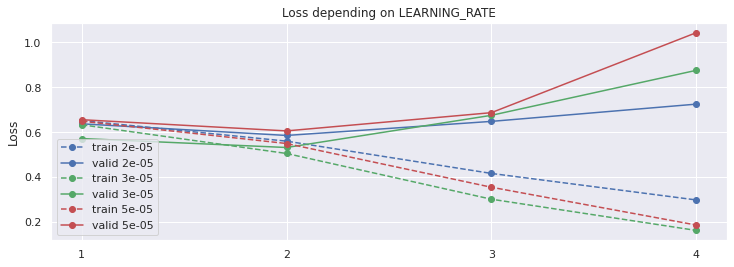

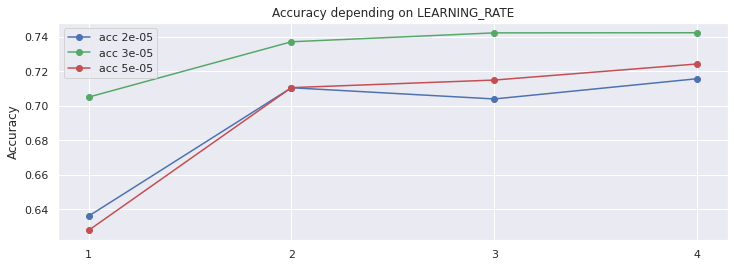

In [ ]:
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (12.11,4)

# plot the learning curves
plt.plot([1, 2, 3, 4], df_lr_2e['train loss'].values, 'b--o', label='train 2e-05')
plt.plot([1, 2, 3, 4], df_lr_2e['valid loss'].values, 'b-o', label='valid 2e-05')

plt.plot([1, 2, 3, 4], df_lr_3e['train loss'].values, 'g--o', label='train 3e-05')
plt.plot([1, 2, 3, 4], df_lr_3e['valid loss'].values, 'g-o', label='valid 3e-05')

plt.plot([1, 2, 3, 4], df_lr_5e['train loss'].values, 'r--o', label='train 5e-05')
plt.plot([1, 2, 3, 4], df_lr_5e['valid loss'].values, 'r-o', label='valid 5e-05')

plt.title('Loss depending on LEARNING_RATE')
plt.ylabel('Loss')
plt.xticks([1, 2, 3, 4])
plt.legend()
plt.show()


plt.rcParams['figure.figsize'] = (12,4)

# plot the accuracy curves
plt.plot([1, 2, 3, 4], df_lr_2e['valid accur'].values, 'b-o', label='acc 2e-05')
plt.plot([1, 2, 3, 4], df_lr_3e['valid accur'].values, 'g-o', label='acc 3e-05')
plt.plot([1, 2, 3, 4], df_lr_5e['valid accur'].values, 'r-o', label='acc 5e-05')

plt.title('Accuracy depending on LEARNING_RATE')
plt.ylabel('Accuracy')
plt.xticks([1, 2, 3, 4])
plt.legend()
plt.show()

It is important to say that such high accuracy rates can't be achieved every time, because when they were obtained, there wasn't set a random seed for splitting into training and validation parts in [9] cell. It is not a problem that such high accuracy is not achieved every time. If its appearance was caused by a specific set of samples in the training and validation part, this would certainly not give as good accuracy on random test data.

In [ ]:
df_len_64 =  pd.read_csv('./drive/MyDrive/nlp/len64_batch16_lr5e-05_epochs4')
df_len_128 =  pd.read_csv('./drive/MyDrive/nlp/len128_batch16_lr5e-05_epochs4')
df_len_256 =  pd.read_csv('./drive/MyDrive/nlp/len256_batch16_lr5e-05_epochs4')

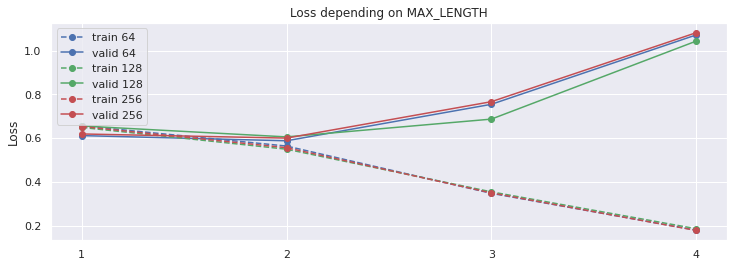

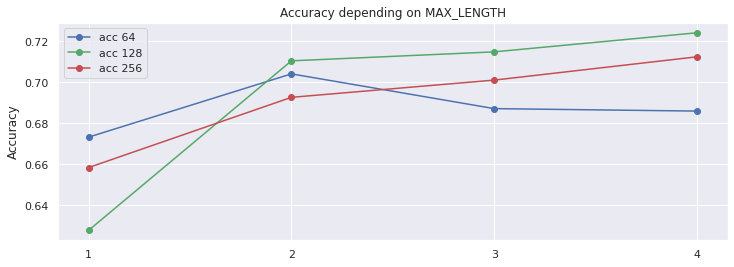

In [ ]:
plt.rcParams['figure.figsize'] = (12.11,4)

# plot the learning curves
plt.plot([1, 2, 3, 4], df_len_64['train loss'].values, 'b--o', label='train 64')
plt.plot([1, 2, 3, 4], df_len_64['valid loss'].values, 'b-o', label='valid 64')

plt.plot([1, 2, 3, 4], df_len_128['train loss'].values, 'g--o', label='train 128')
plt.plot([1, 2, 3, 4], df_len_128['valid loss'].values, 'g-o', label='valid 128')

plt.plot([1, 2, 3, 4], df_len_256['train loss'].values, 'r--o', label='train 256')
plt.plot([1, 2, 3, 4], df_len_256['valid loss'].values, 'r-o', label='valid 256')

plt.title('Loss depending on MAX_LENGTH')
plt.ylabel('Loss')
plt.xticks([1, 2, 3, 4])
plt.legend()
plt.show()


plt.rcParams['figure.figsize'] = (12,4)

# plot the accuracy curves
plt.plot([1, 2, 3, 4], df_len_64['valid accur'].values, 'b-o', label='acc 64')
plt.plot([1, 2, 3, 4], df_len_128['valid accur'].values, 'g-o', label='acc 128')
plt.plot([1, 2, 3, 4], df_len_256['valid accur'].values, 'r-o', label='acc 256')

plt.title('Accuracy depending on MAX_LENGTH')
plt.ylabel('Accuracy')
plt.xticks([1, 2, 3, 4])
plt.legend()
plt.show()

As expected, training loss are falling with each epoch, and validation losses are growing. This suggests that the model is getting over-fitted to the training data, and is increasingly "doubting" the answers to the validation part. If it is not very easy to identify the most optimal parameter looking at loss changes, then it is easy to choose 3e-05 looking at the accuracy graphs.

In [ ]:
df_batch_16 =  pd.read_csv('./drive/MyDrive/nlp/len128_batch16_lr3e-05_epochs4')
df_batch_32 =  pd.read_csv('./drive/MyDrive/nlp/len128_batch32_lr3e-05_epochs4')

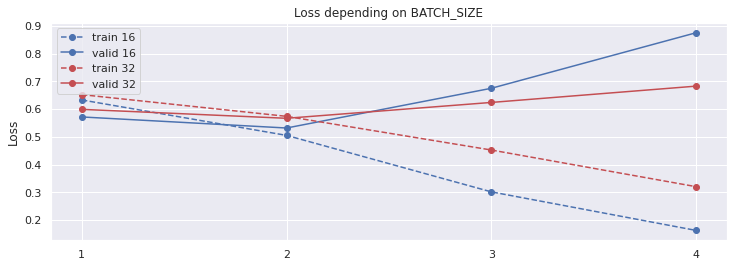

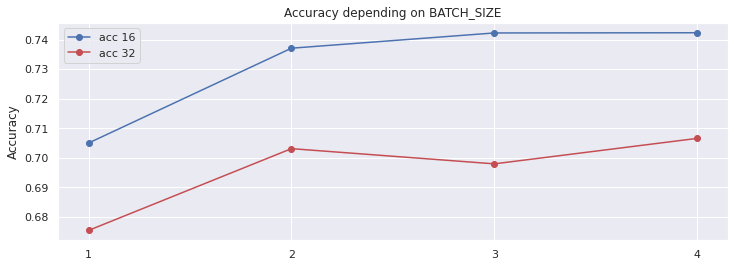

In [ ]:
plt.rcParams['figure.figsize'] = (12.11,4)

# plot the learning curves
plt.plot([1, 2, 3, 4], df_batch_16['train loss'].values, 'b--o', label='train 16')
plt.plot([1, 2, 3, 4], df_batch_16['valid loss'].values, 'b-o', label='valid 16')

plt.plot([1, 2, 3, 4], df_batch_32['train loss'].values, 'r--o', label='train 32')
plt.plot([1, 2, 3, 4], df_batch_32['valid loss'].values, 'r-o', label='valid 32')

plt.title('Loss depending on BATCH_SIZE')
plt.ylabel('Loss')
plt.xticks([1, 2, 3, 4])
plt.legend()
plt.show()


plt.rcParams['figure.figsize'] = (12,4)

# plot the accuracy curves
plt.plot([1, 2, 3, 4], df_batch_16['valid accur'].values, 'b-o', label='acc 16')
plt.plot([1, 2, 3, 4], df_batch_32['valid accur'].values, 'r-o', label='acc 32')

plt.title('Accuracy depending on BATCH_SIZE')
plt.ylabel('Accuracy')
plt.xticks([1, 2, 3, 4])
plt.legend()
plt.show()

In the final model, we will use only 2 training epochs. This way we will be able to avoid overfitting.

# Evaluating on test data

Here we gonna just go through already used pipeline with new data. Literally Сtrl+C Сtrl+V was used here.

In [ ]:
df = pd.read_json('./drive/MyDrive/nlp/val.jsonl', lines=True)

In [ ]:
# preparing data for BERT model
df['encoded_dict'] = df.progress_apply(lambda x: tokenizer.encode_plus(
                                                 text = x['question'],         # 1st sentence to encode
                                                 text_pair = x['passage'],     # 2nd sentence to encode
                                                 add_special_tokens = True,    # add '[CLS]' and '[SEP]'
                                                 max_length = MAX_LENGTH,      # pad & truncate all sentences
                                                 pad_to_max_length = True,
                                                 return_attention_mask = True, # construct attention masks
                                                 return_tensors = 'pt'         # return pytorch tensors
                                                 ), axis=1)

  0%|          | 0/3270 [00:00<?, ?it/s]

In [ ]:
# extracting useful features from the dictionary
df['input_ids'] = df['encoded_dict'].apply(lambda x: x['input_ids'])
df['attention_mask'] = df['encoded_dict'].apply(lambda x: x['attention_mask'])

In [ ]:
# BERT needs integer numbers as classification marks 
df['label'] = df['label'].apply(int)

In [ ]:
# transformation the data to tensor form for further putting it into the model
input_ids_tf = torch.cat(list(df['input_ids']), dim=0)
attention_masks_tf = torch.cat(list(df['attention_mask'].values), dim=0)
labels_tf = torch.tensor(list(df['label']))

Randomized splitting data into training and validation parts. 

In [ ]:
# combine the inputs into a TensorDataset
test_df = TensorDataset(input_ids_tf, attention_masks_tf, labels_tf)

In [ ]:
# creating data loader
test_dataloader = DataLoader(test_df,                          # the training samples
                             sampler = RandomSampler(test_df), # select batches randomly
                             batch_size = batch_size)           # trains with this batch size

In [ ]:
## TEST PART

print('\n  Testing...')

t0 = time.time()

# put the model in evaluation mode: the dropout layers behave differently during evaluation
model.eval()

# tracking variables 
total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0

# evaluate data for one epoch
for batch in test_dataloader:
    
    # batch contains three pytorch tensors: [0] - input ids, [1] - attention masks, [2]-  labels;
    # as we unpack the batch, we'll also copy each tensor to the GPU using the 'to' method
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    # tell pytorch not to compute gradient during the forward pass (we don't need back propagation now)
    with torch.no_grad():        

        # forward pass, calculate logit predictions;
        # the 'logits' are the output values prior to applying an activation function like the softmax
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask,
                             labels=b_labels).to_tuple()
        
    # accumulate the test loss
    total_eval_loss += loss.item()

    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # calculate the accuracy for this batch of test sentences, and accumulate it over all batches
    # total_eval_accuracy += accuracy_score(label_ids, logits)
    total_eval_accuracy += flat_accuracy(logits, label_ids)
    

# report the final accuracy for this test run
avg_test_accuracy = total_eval_accuracy / len(test_dataloader)
print(f'    accuracy: {avg_test_accuracy:.2f}')

# calculate the average loss over all of the batches
avg_test_loss = total_eval_loss / len(val_dataloader)

# measure how long the test run took
test_time = strftime('%H:%M:%S', gmtime((time.time() - t0)))

print(f'    test loss: {avg_test_loss:.2f}')
print('    test took: ' + test_time + '\n')

# record all statistics from this epoch
test_stats = {'test loss': avg_test_loss,
              'test accur': avg_test_accuracy,
              'test time': test_time}


  Testing...
    accuracy: 0.72
    test loss: 1.98
    test took: 00:00:24



In [ ]:
test_accuracy = test_stats['test accur']
print(f'max accuracy is{test_accuracy: .4}, it\'s {(test_accuracy-0.622)*100: .3}% better then baseline')

max accuracy is 0.7189, it's  9.69% better then baseline


So we have:
* an increase of >3% relative to the baseline for a manually made vectorizer, on the basis of which classical vectorization algorithms were tested (one of them was specially tuned)
* an increase of >7% for the BERT vectorizer, on the basis of which classical vectorization algorithms were also tested
* an increase of >9% for the BERT neural network based on a pre-training deep learning network

 It would be possible to try some things to improve the results:
 * for the final method of solving the problem, цу can take the same pre-training model that was used in the second method, perhaps a corpus of texts consisting of questions and answers (even if not only with Yes /No answers) would work tutu better than the basic one
 * it would definitely improve the metrics in each method of applying cross-validation, so we would mostly compensate for overfitting
 * we could just add some more data, for example, combine the train, test and val jsonl-files, then allocate about 10 percent for deferred testing, and apply the mentioned cross-validation in the remaining training part